#### Target : Cluster data first, then predict duration depending in the cluster.

In [1]:
#Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime


In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [ ]:
from sklearn.manifold import TSNE
# for visualizaion of data with high number of dimension

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
from yellowbrick.cluster import KElbowVisualizer

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
sns.set_style('dark')

In [6]:
taxi=pd.read_csv('train.csv')
#Init_test=pd.read_csv('test.csv')
# not sure we can use test csv as Y is missing ==>cannot check++> will have to split the train file

In [7]:
taxi.shape

(1458644, 11)

In [ ]:
# to_drop=['store_and_fwd_flag']
# Insight A creuser: vendor id, l organisation du taxi à new york
#weather_data_nyc_centralpark_2016
# 2 providers 

# WEATHER DATA

In [8]:
weather=pd.read_csv('weather_data_nyc_centralpark_2016(1).csv')

In [ ]:
weather.isnull().sum()

In [ ]:
weather.dtypes
# changer le type de la date de preicipitation et snow columns

In [ ]:
weather.head()

In [ ]:
weather['maximum temperature'].unique()

In [ ]:
weather.date

In [9]:
#transform date from day-month-year to year-month-day in weather file
weather['date']=pd.to_datetime(weather.date)


In [10]:
# Day of year
weather['day_nb'] = weather.date.dt.dayofyear

In [11]:
#check if average temperature  is correct
((weather["maximum temperature"]+weather["minimum temperature"])/2==weather['average temperature']).sum()


366

In [ ]:
#weather['date'].map(lambda x :str(x)[:10])

# TAXI DATA

In [12]:

taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [ ]:
taxi.isnull().sum()

In [ ]:

taxi.pickup_datetime.unique()

In [13]:
taxi['date']=pd.to_datetime(taxi['pickup_datetime'])

In [14]:
# Month of year
taxi['month'] = taxi['date'].dt.month_name()
# Week of year
taxi['week_nb'] = taxi['date'].dt.week
# Day of week
taxi['weekday'] = taxi['date'].dt.day_name()
# Day of year (quantieme)
taxi['day_nb'] = taxi['date'].dt.dayofyear
# Hour of the day 
taxi['hour'] = taxi['date'].dt.hour
# Day of th emonth
taxi['Month_day'] = taxi['date'].dt.day


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [ ]:
# Timestamp.isocalendar to dig in

In [ ]:
taxi['month'].unique()

In [ ]:
# Month of the taxi "ride":
#taxi['Month']=taxi['pickup_datetime'].map(lambda x :x[5:7])
#Seasons:
#Not enough data to use seasons and weather so just
#dct_seasons={1:'winter',2:'winter',12:'winter', 3:'spring', 4: 'spring', 5:'spring', 6:'summer',7:'summer',8:'summer',9:'automn',10:'automn',11:'automn'}
#taxi['season']=taxi['month'].map(dct_seasons)

In [ ]:
taxi['season'].unique()

In [ ]:
# check why automn is not visible ==>Only 1 semester of data

In [ ]:
# Check duration of the transport

In [15]:
taxi['ride_duration']=pd.to_datetime(taxi['dropoff_datetime'])-pd.to_datetime(taxi['pickup_datetime'])

# MERGING TABLES

In [16]:
df = taxi.merge(weather, how='left', on='day_nb')

In [17]:
df.drop_duplicates(inplace=True)

In [ ]:
df.columns

In [18]:
# Check if trip_duration is ok. a faire une fois conversion sec faite==>OK
(df.trip_duration==df.ride_duration).sum()

0

In [19]:
df.ride_duration

0         0 days 00:07:35
1         0 days 00:11:03
2         0 days 00:35:24
3         0 days 00:07:09
4         0 days 00:07:15
                ...      
1458639   0 days 00:12:58
1458640   0 days 00:10:55
1458641   0 days 00:12:44
1458642   0 days 00:06:13
1458643   0 days 00:03:18
Name: ride_duration, Length: 1458644, dtype: timedelta64[ns]

In [ ]:
df.passenger_count.value_counts()


In [20]:
dct_passenger={1:1,2:2,3:3,4:4,5:5,6:6,0:np.NaN,7:np.NaN,9:np.NaN,8:np.NaN}

In [21]:
#We focus only on ride with at least 1 person, and rides with more than 6 people are too rare to be taken into account
df['new_passenger_count']=df.passenger_count.map(dct_passenger)

In [ ]:
df.isnull().sum()

In [22]:
# conversion from inch to mm.T set. arbitrary to a small number close to 0 but not 0

df['precipitation_mm']=df.precipitation.map(lambda x: float(x)*25.4 if x!='T'else 1e-5*25.4)

In [ ]:
#df['precipitation_mm'].value_counts().sort_values()

In [ ]:
#df.precipitation.value_counts().sort_values()

In [23]:
df['snow fall'].value_counts()

0.0     1063582
0        294364
T         52305
0.4       15975
0.2        8805
1.4        7373
2.5        7344
0.5        7248
27.3       1648
Name: snow fall, dtype: int64

In [24]:
df['snow_fall_mm']=df['snow fall'].map(lambda x: float(x)*25.4 if x!='T'else 1e-5*25.4)

In [25]:
df['snow depth'].value_counts()

0     1339426
T       46098
6       27615
4        7670
9        7571
1        7344
17       6941
2        6512
19       6084
22       3383
Name: snow depth, dtype: int64

In [26]:
df['snow_depth_mm']=df['snow depth'].map(lambda x: float(x)*25.4 if x!='T'else 1e-5*25.4)

In [27]:
#conversion from Fanrenheit degrees to Celsius degrees:(T(°F) - 32) × 5/9
df['average temperature_C']=df['average temperature'].map(lambda x: (x-32)*5/9)

In [ ]:
df['average temperature_C'].value_counts()

In [ ]:
df.columns

In [ ]:
df.trip_duration.value_counts().sort_values(ascending=False)

In [ ]:
#df[df.trip_duration>'0 days 02:00:00']

In [31]:
#We will drop taxi ride above 2hours in a first time'
#df[df.trip_duration>'0 days 02:00:00'].trip_duration.value_counts()

In [28]:
#We will drop taxi rides above 2hours in a first time'
taxi['ride_duration']=taxi['ride_duration'].map(lambda x : x if x<=datetime.timedelta(hours=2) else np.NaN)

In [29]:
df['ride_duration']=df['ride_duration'].map(lambda x : x if x<=datetime.timedelta(hours=2) else np.NaN)

In [30]:
df['ride_duration'].max()

Timedelta('0 days 01:59:51')

In [32]:
df.isnull().sum()

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
date_x                      0
month                       0
week_nb                     0
weekday                     0
day_nb                      0
hour                        0
Month_day                   0
ride_duration            2253
date_y                      0
maximum temperature         0
minimum temperature         0
average temperature         0
precipitation               0
snow fall                   0
snow depth                  0
new_passenger_count        65
precipitation_mm            0
snow_fall_mm                0
snow_depth_mm               0
average temperature_C       0
dtype: int64

In [33]:
#drop all rows with missing values
df=df.dropna()

In [34]:

df['ride_duration_seconds']=df['ride_duration'].map(lambda x:x.total_seconds())

<AxesSubplot:xlabel='ride_duration_seconds'>

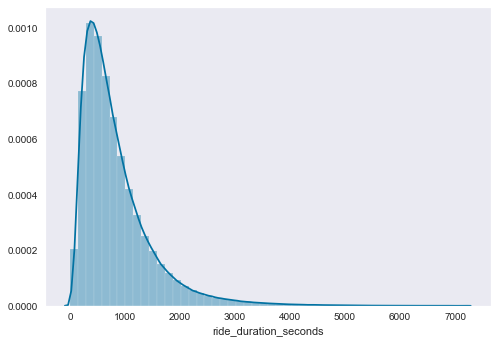

In [35]:
sns.distplot(df['ride_duration_seconds'])
# duration is a log normal distribution

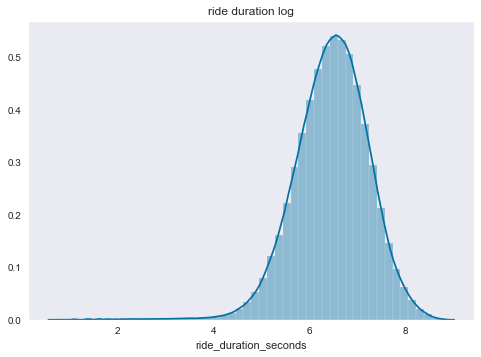

In [36]:

sns.distplot(np.log1p(df['ride_duration_seconds']))
plt.title('ride duration log')
plt.show()

In [37]:
df['ride_duration_seconds'].mean()/60
#Average ride is 13,9min is this sample
 #?? hypothesis testing? est-ce possible avec une distribution log normale

13.93498953188398

In [38]:
df['ride_duration_seconds'].median()/60

11.016666666666667

In [39]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,week_nb,day_nb,hour,...,ride_duration,maximum temperature,minimum temperature,average temperature,new_passenger_count,precipitation_mm,snow_fall_mm,snow_depth_mm,average temperature_C,ride_duration_seconds
count,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,...,1456327,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06,1.456327e+06
mean,1.534289e+00,1.663978e+00,-7.397350e+01,4.075093e+01,-7.397342e+01,4.075181e+01,8.360994e+02,1.383904e+01,9.183331e+01,1.360657e+01,...,0 days 00:13:56.099371913,6.176388e+01,4.673190e+01,5.424789e+01,1.663978e+00,2.248417e+00,1.487595e+00,1.032141e+01,1.235994e+01,8.360994e+02
std,4.988231e-01,1.313548e+00,7.090150e-02,3.285717e-02,7.064270e-02,3.588023e-02,6.542966e+02,8.563963e+00,5.156596e+01,6.399397e+00,...,0 days 00:10:54.296612538,1.697808e+01,1.571624e+01,1.614487e+01,1.313548e+00,5.935904e+00,2.386179e+01,5.704924e+01,8.969375e+00,6.542966e+02
min,1.000000e+00,1.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,0 days 00:00:01,1.500000e+01,-1.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.388889e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073736e+01,-7.399133e+01,4.073589e+01,3.970000e+02,7.000000e+00,4.800000e+01,9.000000e+00,...,0 days 00:06:37,4.900000e+01,3.600000e+01,4.250000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.833333e+00,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075411e+01,-7.397975e+01,4.075453e+01,6.610000e+02,1.300000e+01,9.200000e+01,1.400000e+01,...,0 days 00:11:01,6.100000e+01,4.600000e+01,5.350000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.194444e+01,6.610000e+02
75%,2.000000e+00,2.000000e+00,-7.396734e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03,2.000000e+01,1.360000e+02,1.900000e+01,...,0 days 00:17:53,7.600000e+01,6.100000e+01,6.950000e+01,2.000000e+00,1.016000e+00,0.000000e+00,0.000000e+00,2.083333e+01,1.073000e+03
max,2.000000e+00,6.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,7.191000e+03,5.300000e+01,1.820000e+02,2.300000e+01,...,0 days 01:59:51,9.200000e+01,7.500000e+01,8.300000e+01,6.000000e+00,5.867400e+01,6.934200e+02,5.588000e+02,2.833333e+01,7.191000e+03


In [ ]:
df.pickup_longitude .value_counts()

In [ ]:
df.pickup_latitude.value_counts()

In [ ]:
df.dropoff_longitude .value_counts()

In [ ]:
df.dropoff_latitude.value_counts()

In [40]:
#google is my friend
#Voici une version numpy vectorisée de la même fonction:

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km
#Les entrées sont toutes des tableaux de valeurs, et il devrait pouvoir faire des millions de points instantanément. L’exigence est que les entrées soient ndarrays mais les colonnes de votre table de pandas fonctionneront.

#Par exemple, avec des valeurs générées aléatoirement:

#La lecture en boucle dans des tableaux de données est très lente en python. Numpy fournit des fonctions qui fonctionnent sur des tableaux de données entiers, ce qui vous permet d'éviter les boucles et d'améliorer considérablement les performances.

#Ceci est un exemple de vectorisation .

In [ ]:
# distance de manhattan

In [41]:
df['distance_KM']=haversine_np(df['pickup_longitude'],df['pickup_latitude'],df['dropoff_longitude'],df['dropoff_latitude'])

In [42]:
df['distance_KM'].value_counts().sort_values(ascending=False)

0.000000     5884
0.000424      114
0.000424       53
0.000848       46
0.001273       40
             ... 
5.194750        1
1.143717        1
1.758514        1
18.595974       1
7.492507        1
Name: distance_KM, Length: 1449987, dtype: int64

In [43]:
df[df['distance_KM']==0.000000].store_and_fwd_flag.value_counts()
# pas d'enregistrement du trajet? sur 5884 courses latitute et longitude identiques
#On drope

N    5819
Y      65
Name: store_and_fwd_flag, dtype: int64

In [44]:
#ne garder que les lignes ou la distance est non null
df=df[df['distance_KM']!=0.000000]

In [ ]:
#df['distance_KM'].value_counts().sort_values(ascending=False)

In [45]:
dct_work={'Monday':1, 'Sunday':0, 'Tuesday':1, 'Wednesday':1, 'Saturday':0, 'Friday':1,
       'Thursday':1}

In [46]:
df.weekday.unique()

array(['Monday', 'Sunday', 'Tuesday', 'Wednesday', 'Saturday', 'Friday',
       'Thursday'], dtype=object)

In [47]:
df['working_days']=df.weekday.map(dct_work)
#ranger jour dans le bon sens.

<AxesSubplot:xlabel='working_days', ylabel='hour'>

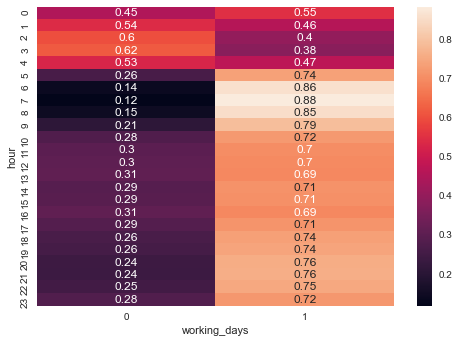

In [48]:
sns.heatmap(pd.crosstab(df.hour,df.working_days,normalize='index'),annot=True)

<AxesSubplot:xlabel='weekday', ylabel='hour'>

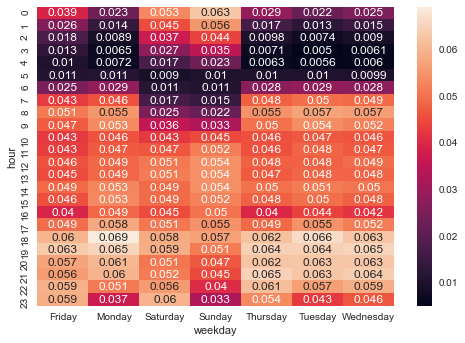

In [49]:
sns.heatmap(pd.crosstab(df.hour,df.weekday,normalize='columns'),annot=True)
#repartition des courses pour chaque jour 0 lundi, 6 dimanche
# reprise des bus/metro à quel heure? 5h. heures fermeture bars/boite de nuit.

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

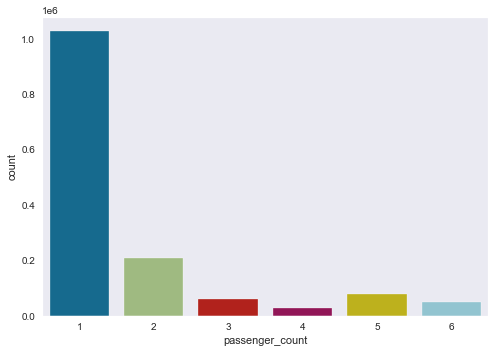

In [50]:
sns.countplot(df.passenger_count)
# majority of 1 passenger - ride

<AxesSubplot:xlabel='weekday', ylabel='passenger_count'>

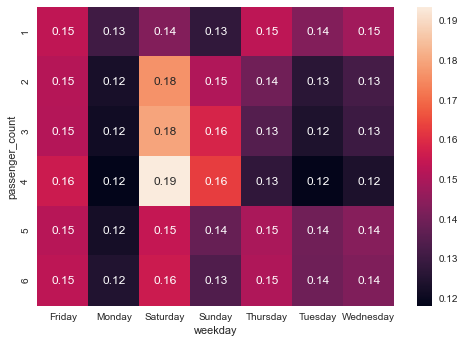

In [51]:
sns.heatmap(pd.crosstab(df.passenger_count,df.weekday,normalize='index'),annot=True)
# sur quels jour sont plutot les passager solo, duo, ou plus

In [52]:
to_drop=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime','store_and_fwd_flag','trip_duration','date_y','maximum temperature','minimum temperature', 'precipitation','snow fall','snow depth','average temperature']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


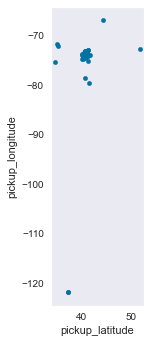

In [54]:
#MAin rides in Manhattan?,and someone went to Ney Jersey.?
ax=df[["pickup_latitude", "pickup_longitude"]].plot.scatter(x="pickup_latitude", y="pickup_longitude")
ax.set_aspect('equal', 'box')


In [55]:
#fichier pour viz tableau
df[["pickup_latitude", "pickup_longitude"]].to_csv('Depatures_forVIZ')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


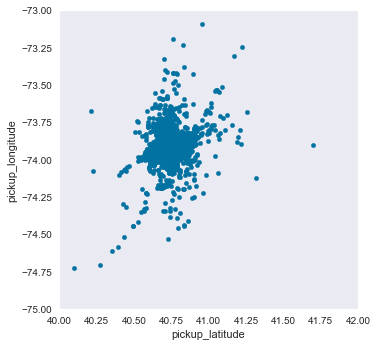

In [56]:
#Zoom

ax=df[["pickup_latitude", "pickup_longitude"]].plot.scatter(x="pickup_latitude", y="pickup_longitude")
ax.set_xlim(40, 42)
ax.set_ylim(-75, -73)
ax.set_aspect('equal', 'box')
#https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/axis_equal_demo.html

In [57]:
df.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,week_nb,day_nb,hour,...,minimum temperature,average temperature,new_passenger_count,precipitation_mm,snow_fall_mm,snow_depth_mm,average temperature_C,ride_duration_seconds,distance_KM,working_days
vendor_id,1.000000,0.287590,0.008268,0.002113,0.001755,0.004919,0.008154,-0.001821,-0.006207,0.009065,...,-0.004627,-0.004678,0.287590,0.000693,0.000149,0.006366,-0.004678,0.008154,0.008572,-0.002273
passenger_count,0.287590,1.000000,0.002304,-0.004989,-0.000380,-0.002501,0.014656,0.004690,-0.002117,0.008964,...,-0.002298,-0.002147,1.000000,0.000539,0.000265,0.001285,-0.002147,0.014656,0.010351,-0.028335
pickup_longitude,0.008268,0.002304,1.000000,0.038989,0.768931,0.122017,0.201490,0.007065,0.004707,0.010460,...,0.003046,0.003223,0.002304,0.000163,-0.002122,0.003686,0.003223,0.201490,0.271481,0.013100
pickup_latitude,0.002113,-0.004989,0.038989,1.000000,0.140700,0.438231,-0.212957,-0.005964,-0.002881,0.011742,...,0.000739,0.000393,-0.004989,-0.001200,-0.005319,-0.000683,0.000393,-0.212957,-0.222418,0.036226
dropoff_longitude,0.001755,-0.000380,0.768931,0.140700,1.000000,0.148649,0.118820,0.006360,0.005131,-0.023363,...,0.003782,0.003901,-0.000380,0.000316,0.001099,0.001039,0.003901,0.118820,0.141537,0.001854
dropoff_latitude,0.004919,-0.002501,0.122017,0.438231,0.148649,1.000000,-0.170092,-0.003480,-0.001864,0.014798,...,0.000840,0.000644,-0.002501,-0.000799,-0.002298,-0.000136,0.000644,-0.170092,-0.149872,0.024291
trip_duration,0.008154,0.014656,0.201490,-0.212957,0.118820,-0.170092,1.000000,0.037926,0.060874,0.029438,...,0.024199,0.025693,0.014656,-0.011661,-0.003493,0.021039,0.025693,1.000000,0.709347,0.063741
week_nb,-0.001821,0.004690,0.007065,-0.005964,0.006360,-0.003480,0.037926,1.000000,0.712634,-0.016936,...,0.358302,0.379623,0.004690,-0.052637,-0.046603,-0.184392,0.379623,0.037926,0.020557,-0.035756
day_nb,-0.006207,-0.002117,0.004707,-0.002881,0.005131,-0.001864,0.060874,0.712634,1.000000,-0.003473,...,0.464493,0.497449,-0.002117,-0.028562,-0.047891,-0.226192,0.497449,0.060874,0.016434,0.006875
hour,0.009065,0.008964,0.010460,0.011742,-0.023363,0.014798,0.029438,-0.016936,-0.003473,1.000000,...,-0.000202,0.001037,0.008964,-0.013698,-0.049929,0.014197,0.001037,0.029438,-0.016010,0.090182


<AxesSubplot:>

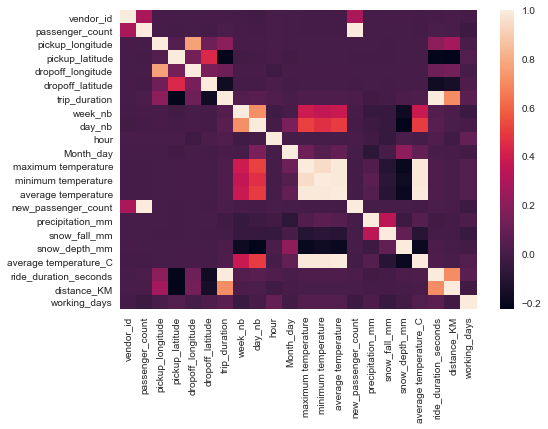

In [58]:
sns.heatmap(df.corr())

In [59]:
df.to_csv('NYC_taxi_clean.csv')

# Modeling

In [ ]:
df.columns

In [ ]:
df.Month_day.value_counts()

In [ ]:
to_dummies=['month','weekday','hour']

In [ ]:
to_drop.extend(['date_x','ride_duration'])

In [ ]:
to_select=['vendor_id','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','month', 'week_nb', 'weekday', 'day_nb',
       'hour', 'new_passenger_count', 'precipitation_mm',
       'snow_fall_mm', 'snow_depth_mm', 'average temperature_C',
       'ride_duration_seconds', 'distance_KM', 'working_days']

In [ ]:
df_ml2=df[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','month',
       'hour', 'new_passenger_count', 'precipitation_mm',
       'snow_fall_mm', 'snow_depth_mm', 'average temperature_C','working_days','Month_day']]


In [ ]:
df_ml2=pd.get_dummies(data=df_ml2, columns=['hour','month'],drop_first=True)

In [ ]:
df_ml2.shape

In [ ]:
#Normalization of data with MinMaxscaler (not standardization since not sure the distribution is normal)
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df_ml2)


# second selection of features

In [ ]:
#df_ml=df[['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','month','weekday',
       'hour']]
# a rajouter passeger count 

In [ ]:
#df_ml=pd.get_dummies(data=df_ml, columns=['hour','weekday','month'],drop_first=True)

In [ ]:
#scaler2 = MinMaxScaler()
#scaled2 = scaler2.fit_transform(df_ml)

###  Find  optimum number of cluster with K-Elbow method

In [ ]:

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
#Model with df ml
#Instantiate the clustering model and visualizer
#model2 = KMeans()
#visualizer = KElbowVisualizer(model2, k=(4,10))

#visualizer.fit(scaled2)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

#### PCA

In [ ]:
#Apply PCA before Kmean ( should optimize  the output (empirical observations) )

In [ ]:
# define PCA toget 85% of explained variance, fit the PCA model and check the number of components; Here 23
pca=PCA(0.85)
pca.fit(scaled)
pca.explained_variance_ratio_

In [ ]:
#apply pCA transformation 
pca_df=pd.DataFrame(pca.transform(scaled), columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21'])

## pca avec df_ml

In [ ]:
# define PCA toget 85% of explained variance, fit the PCA model and check the number of components; Here 23
pca2=PCA(0.85)
pca2.fit(scaled2)
pca2.explained_variance_ratio_

In [ ]:
#apply pCA transformation 
pca_df2=pd.DataFrame(pca2.transform(scaled2), columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21'])

## Calcul de Ypredict

In [ ]:
#model1 Kmeans applied to data transformed with PCA
kmeans1=KMeans(6)
kmeans1=kmeans1.fit(pca_df)
kmeans1.cluster_centers_
# Attribution of class to each record (prediction
df_ml2['cluster1']=kmeans1.predict(pca_df)

In [ ]:
df_ml2.cluster1.value_counts(normalize=True)

In [ ]:
df_ml2Sample=df_ml2.sample(frac=0.001)

In [ ]:
df_ml2Sample.dtypes

In [ ]:
sns.scatterplot(x='PC1',y='PC2', data=pca_df, hue=df_ml2['cluster1'])

In [ ]:
# plot relationship between columns to see how they influence clusters
sns.scatterplot(df_ml2Sample.dropoff_latitude ,df_ml2Sample.dropoff_longitude  ,hue=df_ml2Sample.cluster1)

In [ ]:
#model3 applied to data transformed with PCA
Agg=AgglomerativeClustering(6)
Agg=Agg.fit(pca_df)
Agg.cluster_centers_
# Attribution of class to each record (prediction
df_ml2['cluster3']=Agg.predict(pca_df)

In [ ]:
AgglomerativeClustering

In [ ]:
#MODEL 2 Kmean without PCA

kmeans2=KMeans(6)
kmeans2=kmeans2.fit(scaled)
kmeans2.cluster_centers_
# Attribution of class to each record (prediction
df_ml2['cluster2']=kmeans2.predict(scaled)

In [ ]:
y_kmeans=df_ml2['cluster1']

In [ ]:
X=df_ml2

In [ ]:
df_ml2.cluster2.value_counts(normalize=True)

In [ ]:
# plot relationship between columns to see how they influence clusters
sns.scatterplot(df_ml2.cluster1 ,df_ml2.cluster2)

In [ ]:
#model3 Kmeans applied to data transformed with PCA df_ml
kmeans3=KMeans(6)
kmeans3=kmeans3.fit(pca_df2)
kmeans3.cluster_centers_
# Attribution of class to each record (prediction
df_ml['cluster1']=kmeans3.predict(pca_df2)


In [ ]:
df_ml.cluster1.value_counts(normalize=True)

In [ ]:
sns.scatterplot(x='PC1',y='PC2', data=pca_df2, hue=df_ml['cluster1'])

## Supervised learning

In [ ]:
#model librairies
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from sklearn.model_selection import RepeatedStratifiedKFold

### Hyper parameter Tuning and cross validation

In [ ]:
#kfold=KFold(5, True, 42)
# create 5 sets 4 train 1 test

In [ ]:
#params={'n_neighbors':range(3,10,2), #4
#'weights':['uniform','distance'], #2
#'leaf_size':[30,45], #2
#'p':[2,3]} #2



In [ ]:
#model=GammaRegressor()

#cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

#grid_search=GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, scoring='recall', cv=cv)

In [ ]:
# splitting  dataset into train and test 1
X_train, X_test,y_train,y_test = train_test_split(df_ml2, \
                                                  df.ride_duration_seconds, \
                                                  test_size=1/3, \
                                                  random_state=42)

In [ ]:
# splitting  dataset into train and test 1
X_train, X_test,y_train,y_test = train_test_split(df_ml2, \
                                                  df.new_passenger_count, \
                                                  test_size=1/3, \
                                                  random_state=42)

In [ ]:
#model_list=['LogisticRegression(max_iter=1e8)','GaussianNB()','DecisionTreeClassifier()','RandomForestClassifier()','RandomForestClassifier(max_depth=3)',"RandomForestClassifier(class_weight='balanced')",'SVC()',"SVC(kernel='sigmoid')",'NuSVC(nu=0.1)',"NuSVC(nu=0.1,kernel='sigmoid')",'KNeighborsClassifier(n_neighbors=7)','KNeighborsClassifier(n_neighbors=3)',"KNeighborsClassifier(weights='distance')",'AdaBoostClassifier()','CatBoostClassifier()']



In [ ]:
# Lanceur de models
model_list=['GammaRegressor()','DecisionTreeClassifier()','GaussianNB()','DecisionTreeClassifier()','RandomForestClassifier()','LinearRegression()']

#Ecrire ne classe abvec les modeles
def LaunchAllModels(model_list):
    results=[]
    for i in model_list:
        model=eval(f'{i}')
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        R2=r2_score(y_test,y_pred)
        results.append([i,R2])
    return results
result=LaunchAllModels(model_list) 


In [ ]:
result=pd.DataFrame(result)
result.columns=['Model Name','R^2']
result.round(3)

# Useful code

In [ ]:
taxi.describe(include='all')

In [ ]:
#BasiC EDA 
from pandas_profiling import ProfileReport
#prof = ProfileReport(weather)
#prof.to_file(output_file='outputweather.html')

In [ ]:
#m=TSNE(n_components=2, random_state=0)


#tsne_features=m.fit(df_ml2Sample)
#df_ml2Sample['x']=tsne_features[:,0]
#df_ml2Sample['y']=tsne_features[:,1]
#sns.scatterplot(x='x',y='y',data=df_ml2)
#plt.show()
#sns.scatterplot(x='x',y='y',data=df_ml2,hue=cluster1)
#plt.show()
#sns.scatterplot(x='x',y='y',data=df_ml2,hue=cluster2)
#plt.show()